<a href="https://colab.research.google.com/github/eoinleen/Biophysics-general/blob/main/Dianthus_ratio_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔬 Dianthus Binding Analysis Tool (Bidirectional Signal)
📁 Upload your Excel file with:
   • Column A: Concentration in nM
   • Column B: Ratio values (can increase or decrease)


Saving 296_32_all-redo-for-con.xlsx to 296_32_all-redo-for-con (1).xlsx
✅ File '296_32_all-redo-for-con (1).xlsx' uploaded successfully!
📊 File structure preview:
   Rows: 42
   Columns: [15133.9, 1.0374140349377128]

📋 First few rows:
   15133.900000  1.037414    
0   5044.633333      1.082431
1   1681.544444      1.129558
2    560.514815      1.157818
3    186.838272      1.170691
4     62.279424      1.182151

🔍 Found 1 column pairs:
   Pair 0: 15133.9 (conc nM) & 1.0374140349377128 (ratio)

⚙️ Analysis plan:
   Pairs to fit: [0]
   Pairs to plot as scatter: []

📈 Pair 0 data summary:
   Data points: 42
   Concentration range: 0.1 - 78822.9 nM
   Ratio range: 0.934 - 1.188

🔄 Fitting 1 pairs...

--- Analyzing Pair 0 ---
   Signal direction: Decreases with concentration

📊 Model comparison:
   Hill equation: R² = 0.9251
   One site + non-specific: R² = 0.9250
   One site (decrease): R² = 0.9250
   Best model: Hill equation
✅ Pair 0 - Kd: 3809.3 nM, R²: 0.925
   Standard Error: ± 1.00

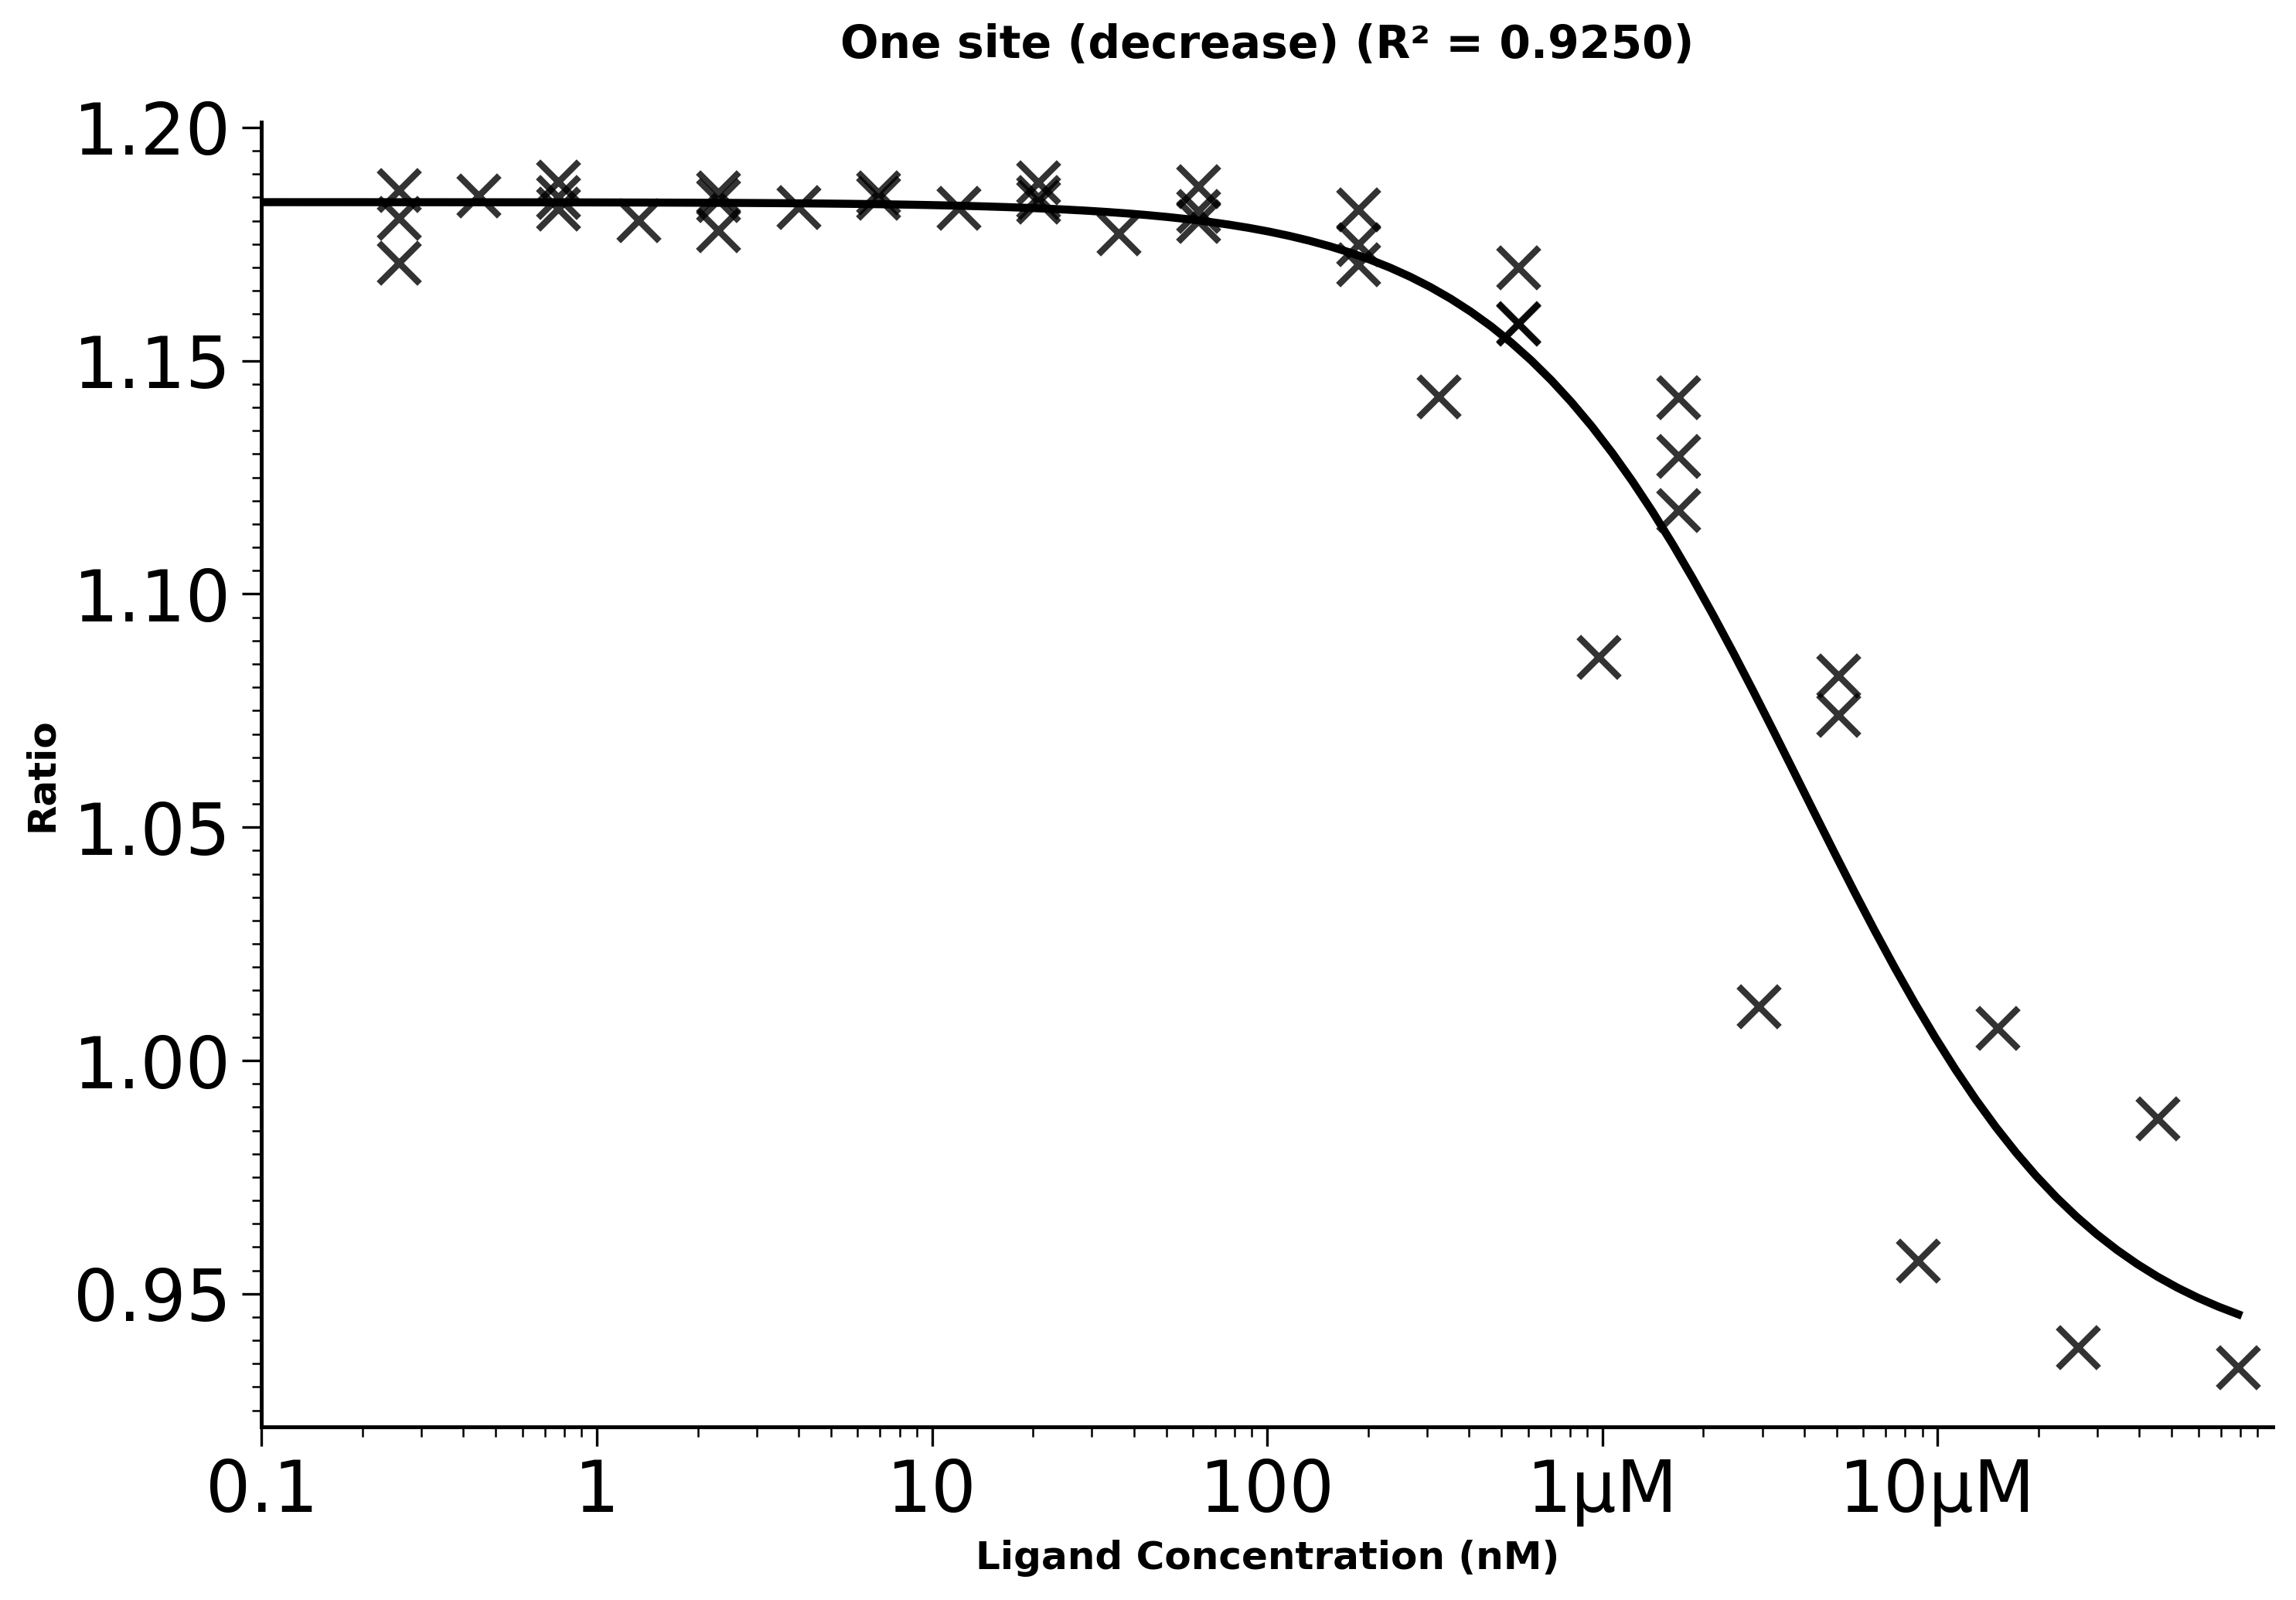


📊 One site (decrease):
   Equation: Y = Top - (Top-Bottom)*X/(Kd+X)
   R²: 0.9250
   Kd: 3.909e-06 M (3909.3 nM)
   Standard Error: ± 7.876e-07 M (± 787.6 nM)
   90% CI: (2613.6 - 5204.9 nM)
   95% CI: (2365.5 - 5453.0 nM)
   Relative error: 20.1%
--------------------------------------------------
✅ Saved: Dianthus_binding_One_site_plus_non-specific_pair0.png


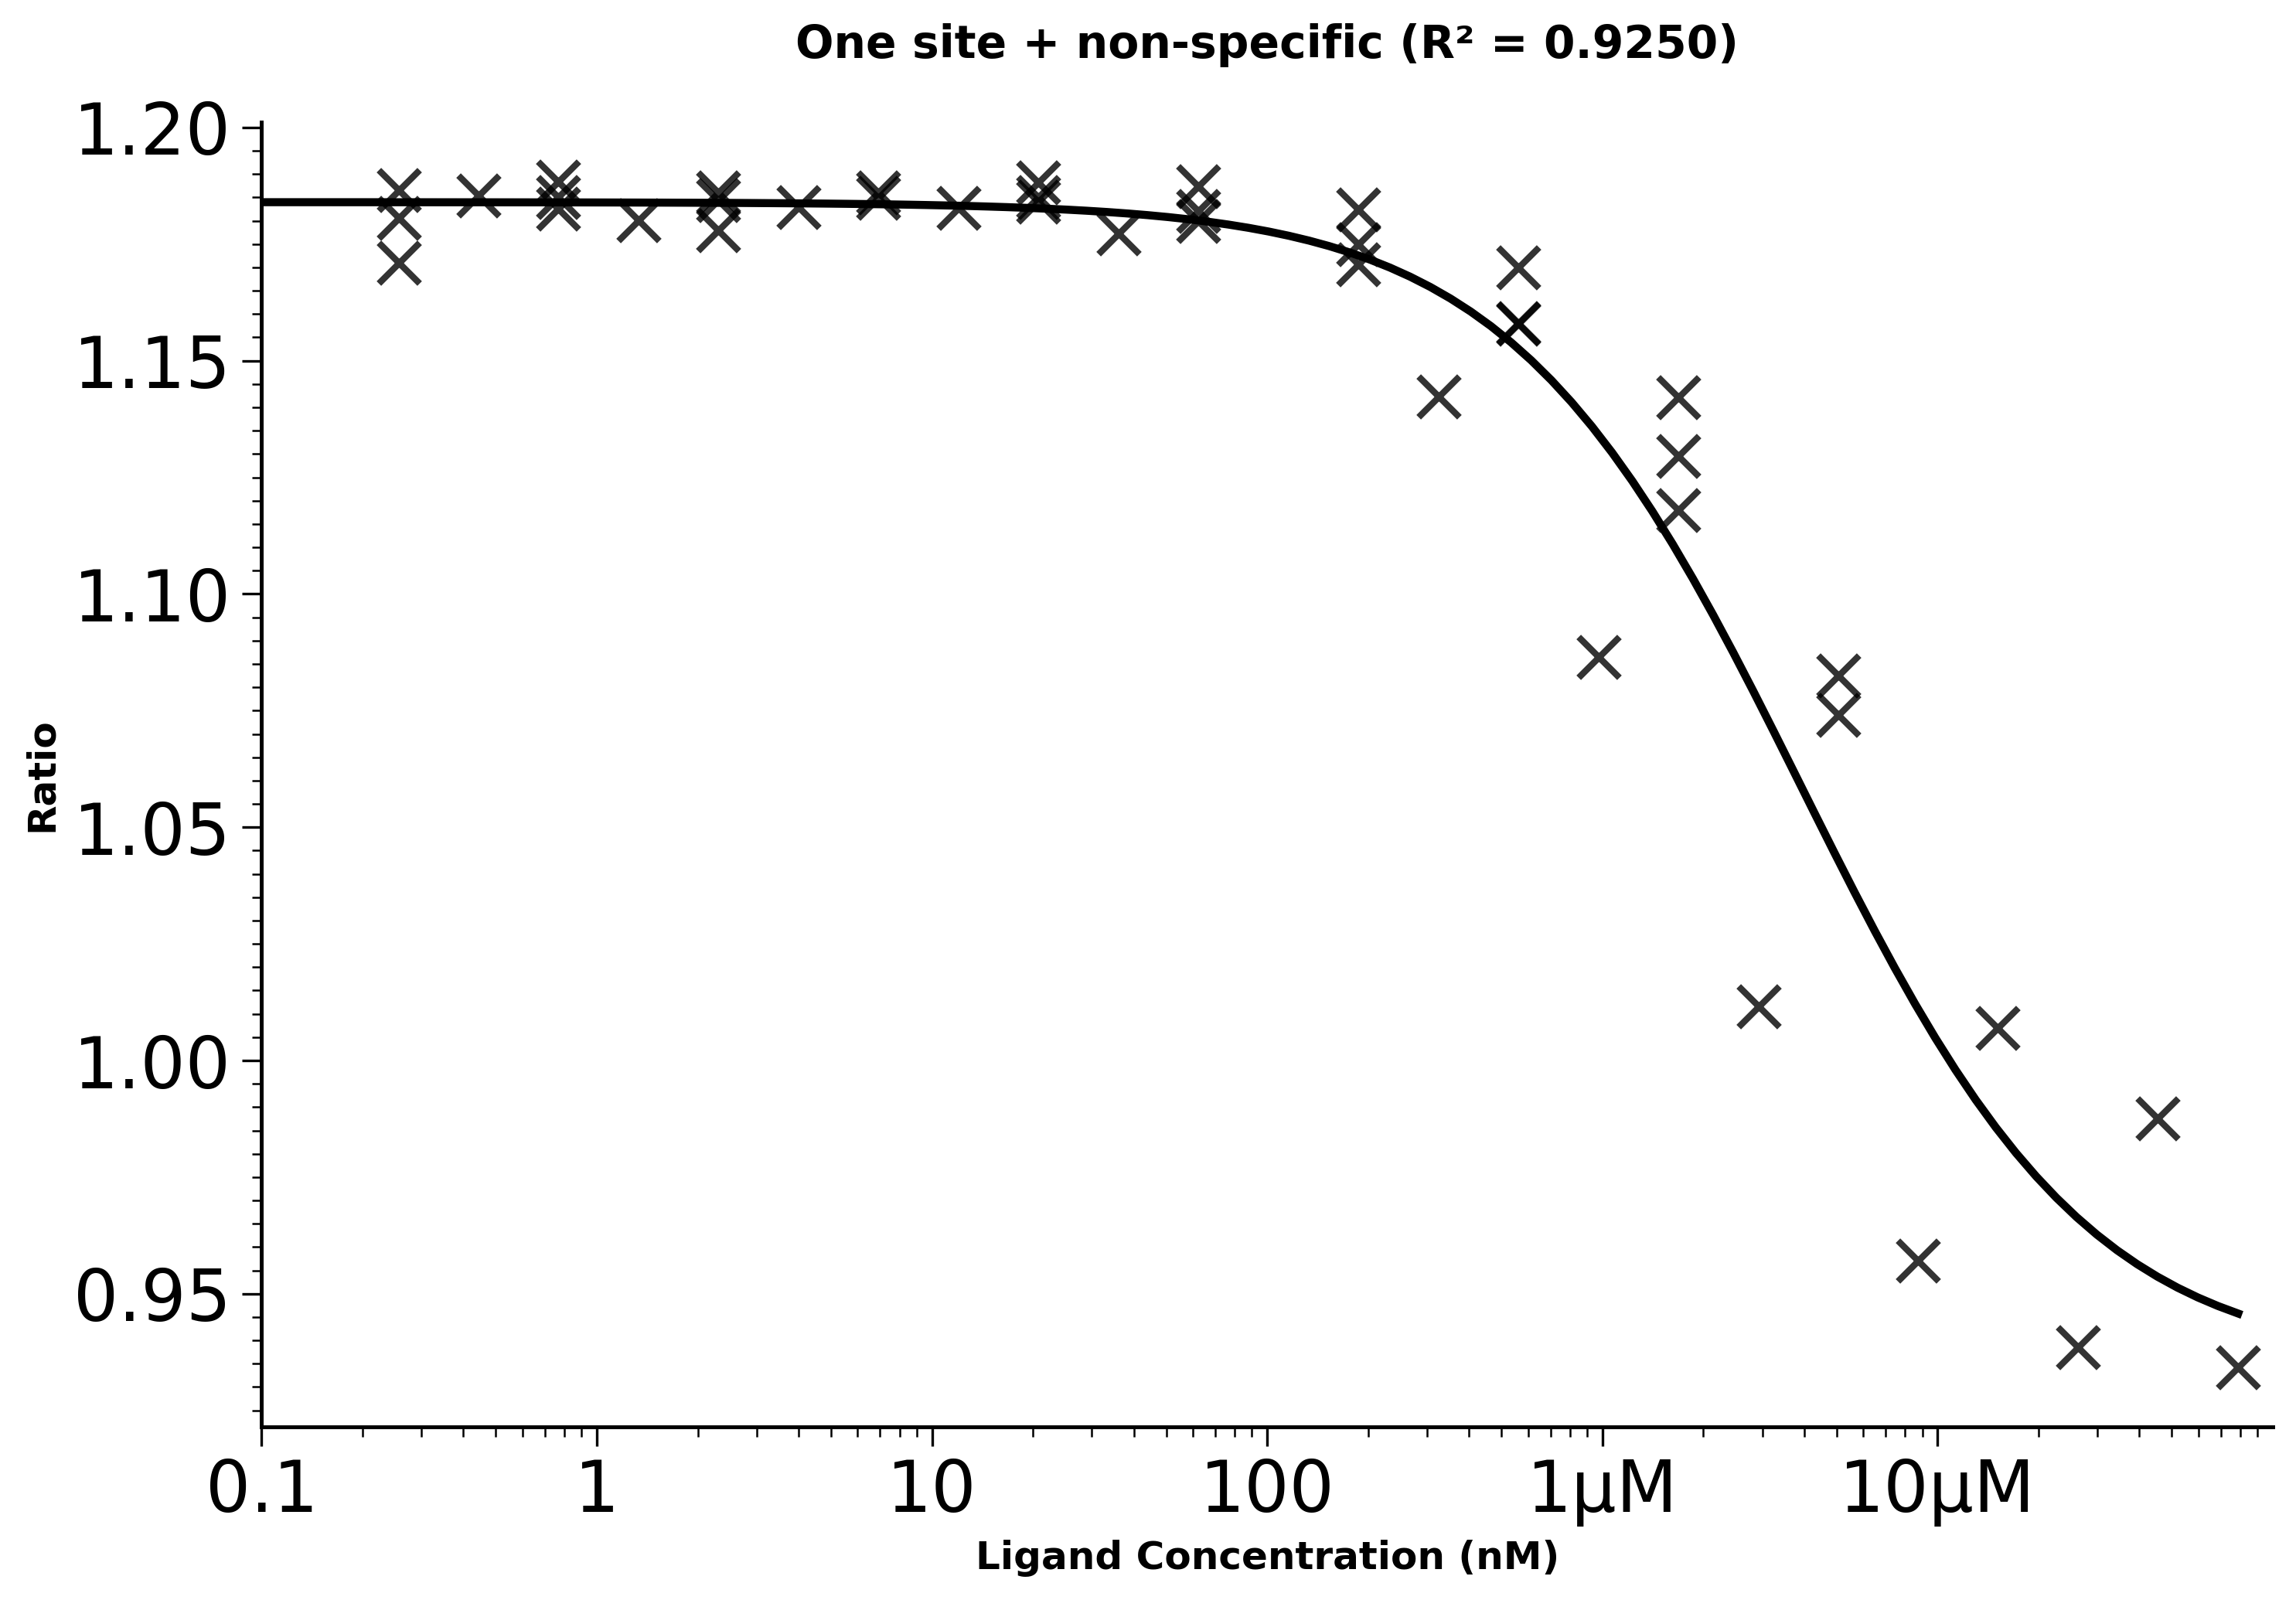


📊 One site + non-specific:
   Equation: Y = Bottom + (Top-Bottom)*X/(Kd+X) + NS*X
   R²: 0.9250
   Kd: 3.919e-06 M (3918.8 nM)
   Standard Error: ± 1.225e-06 M (± 1225.0 nM)
   90% CI: (1903.6 - 5934.0 nM)
   95% CI: (1517.8 - 6319.8 nM)
   Relative error: 31.3%
--------------------------------------------------
✅ Saved: Dianthus_binding_Hill_equation_pair0.png


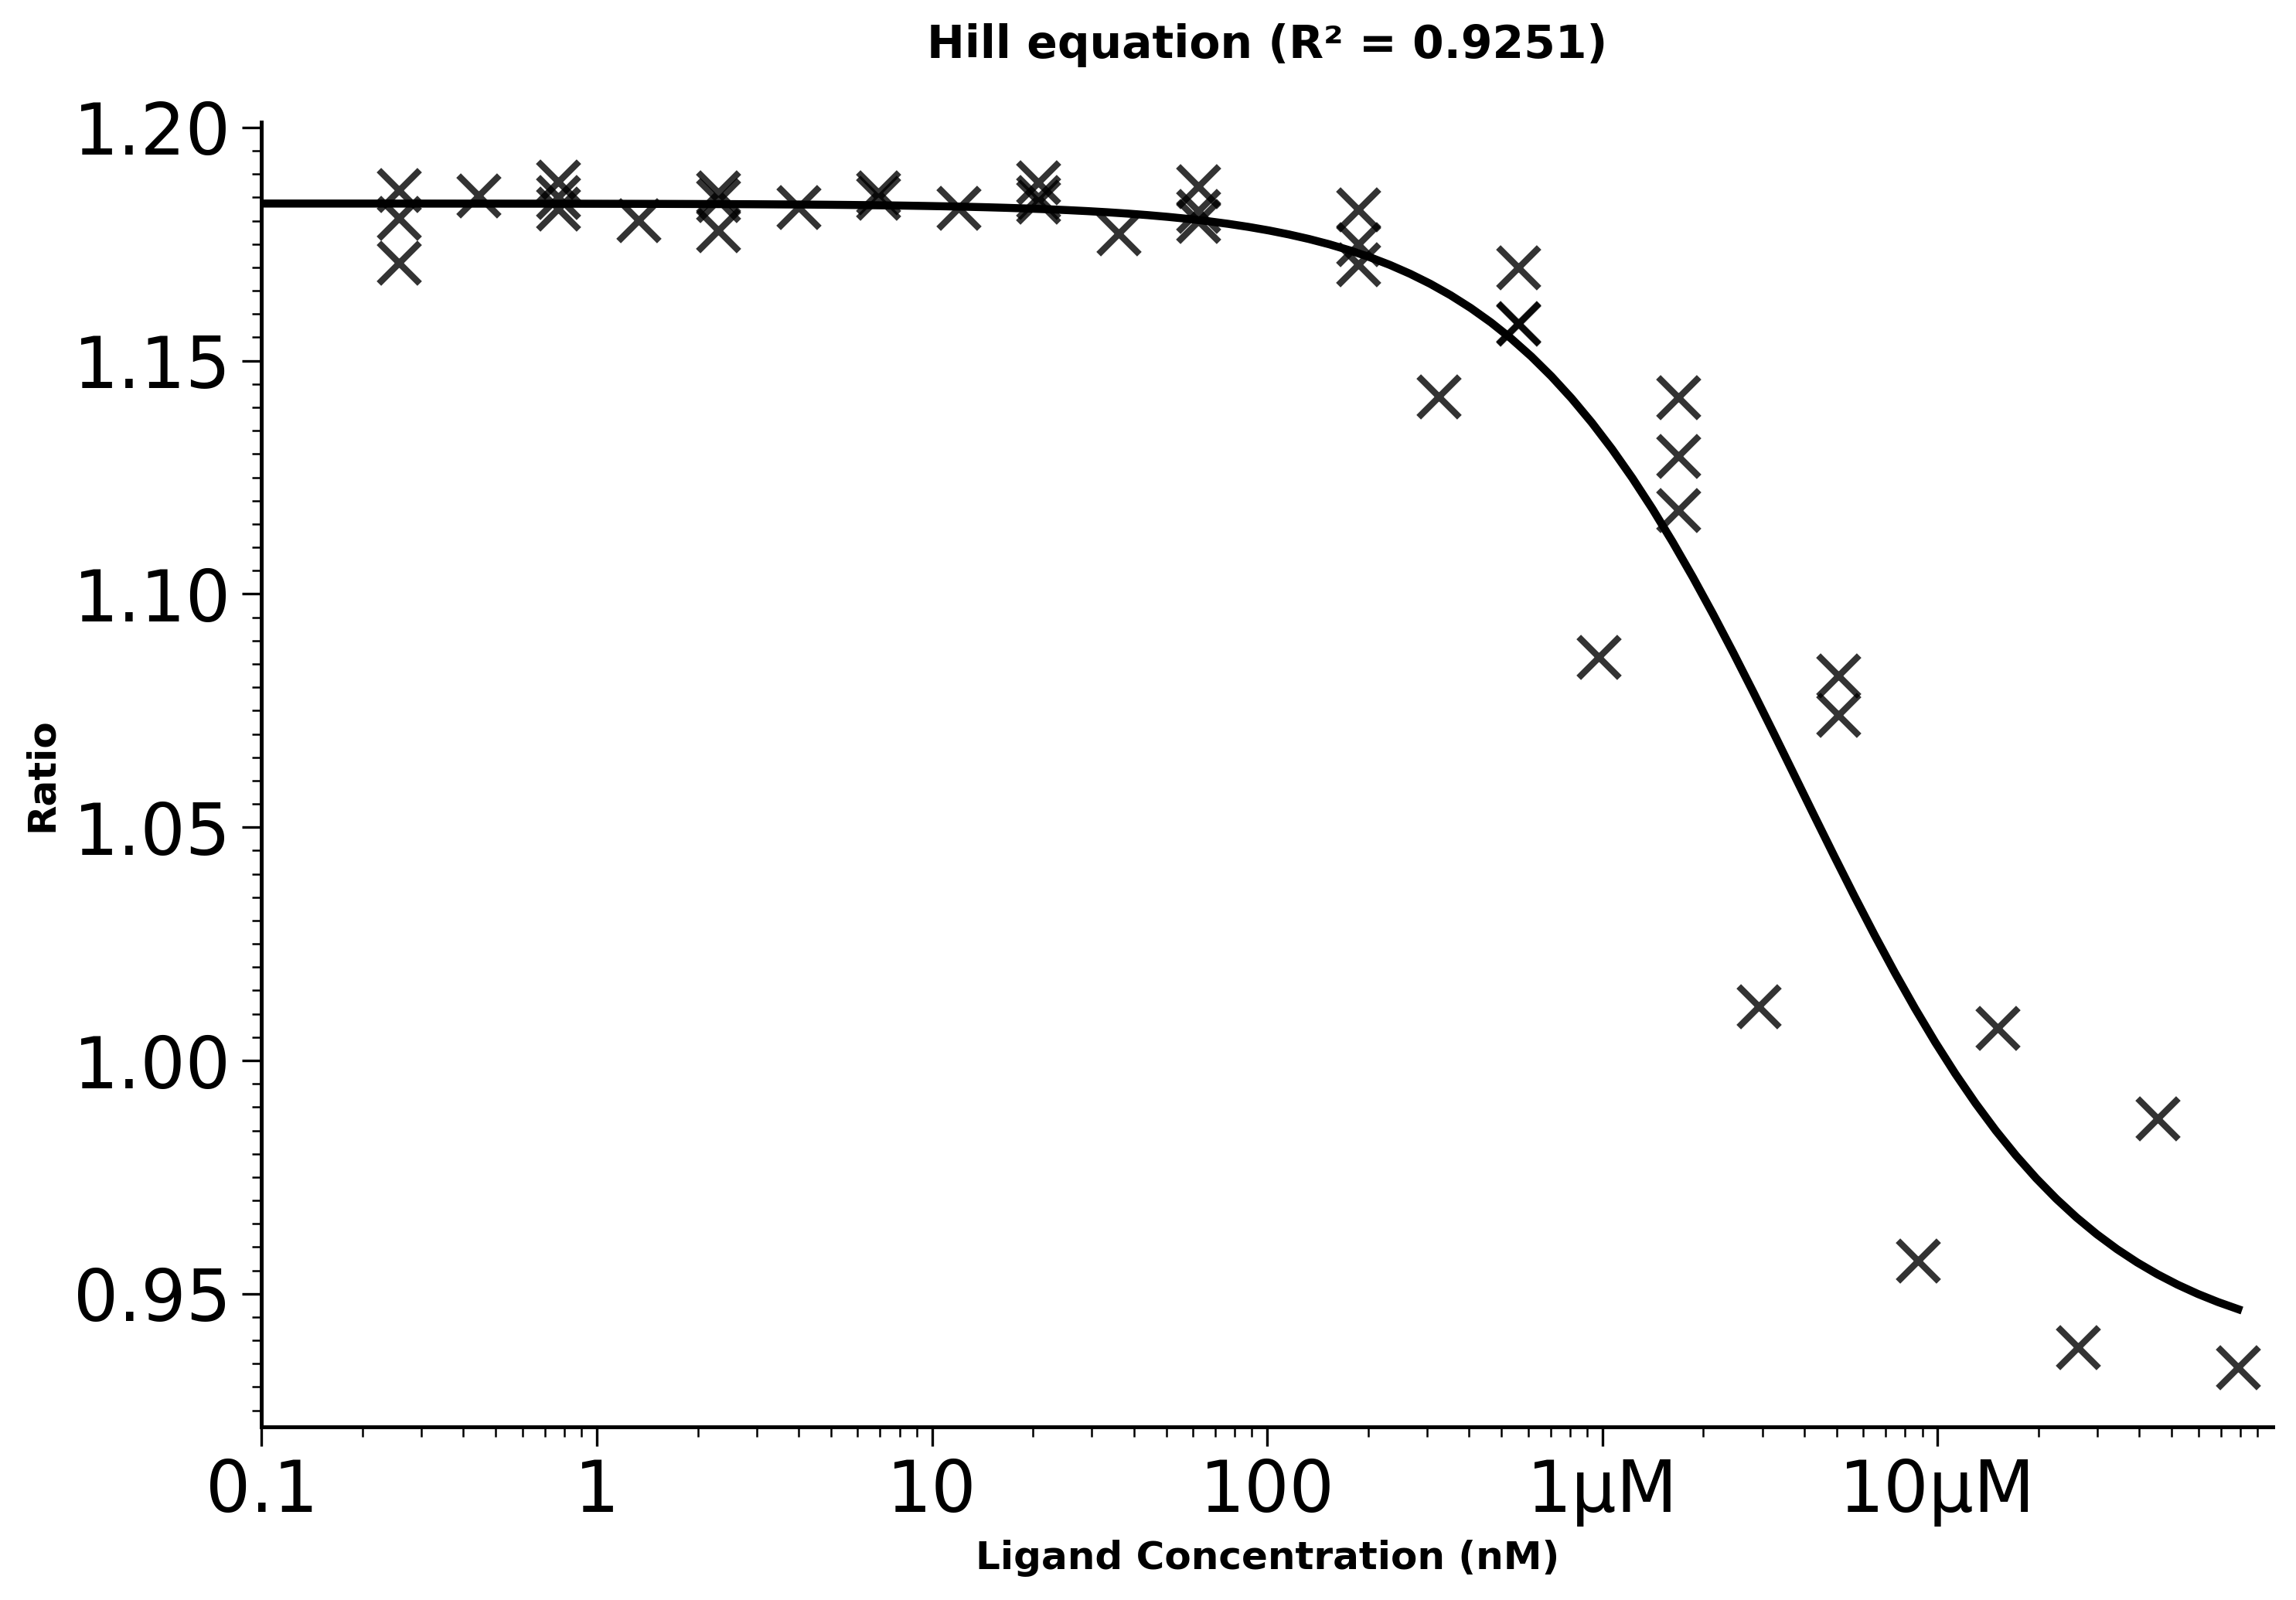


📊 Hill equation:
   Equation: Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)
   R²: 0.9251
   Kd: 3.809e-06 M (3809.3 nM)
   Standard Error: ± 1.004e-06 M (± 1003.9 nM)
   90% CI: (2157.9 - 5460.7 nM)
   95% CI: (1841.7 - 5776.9 nM)
   Relative error: 26.4%
--------------------------------------------------

💾 All model plots saved for Dianthus binding analysis.


In [3]:
"""
Dianthus Binding Assay Analysis Script (Bidirectional Signal)
=============================================================

Author: Claude (Anthropic)
Version: 1.0
Date: 2025

OVERVIEW:
This script analyzes Dianthus binding assay data where the signal can either increase
or decrease upon ligand binding. Unlike TRIC assays, this modality allows for both
positive and negative signal changes depending on the binding mechanism.

INPUT DATA FORMAT:
- Excel files with paired columns: (A,B), (C,D), (E,F), etc.
- Column pattern: Concentration (nM), Ratio values
- Ratio can increase or decrease from baseline upon binding

BINDING MODELS TESTED:
================================================================================

1. ONE SITE BINDING (Increase):
   Y = Bottom + (Top - Bottom) × X/(Kd + X)

   For signals that increase with binding concentration

2. ONE SITE BINDING (Decrease):
   Y = Top - (Top - Bottom) × X/(Kd + X)

   For signals that decrease with binding concentration

3. ONE SITE BINDING WITH NON-SPECIFIC:
   Y = Bottom + (Top - Bottom) × X/(Kd + X) + NS × X

   Includes linear non-specific component

4. HILL EQUATION (Bidirectional):
   Y = Bottom + (Top - Bottom) / (1 + (Kd/X)^n)

   Can handle both increases and decreases with Hill coefficient

ALGORITHM DETAILS:
================================================================================
- Same Levenberg-Marquardt optimization as TRIC script
- Automatic detection of signal direction (increase vs decrease)
- Parameter bounds adapted for bidirectional signals
- Model selection based on R² comparison

================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns
from google.colab import files

# Set minimalist plotting style with Helvetica font
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.grid': False,
    'figure.facecolor': 'none',
    'axes.facecolor': 'none'
})

def analyze_uploaded_file_multi(filename, pairs_to_fit=None, pairs_to_plot=None):
    """
    Load and analyze multiple column pairs from Excel file
    """
    try:
        # Read Excel file
        df = pd.read_excel(filename, engine='openpyxl')

        print(f"📊 File structure preview:")
        print(f"   Rows: {len(df)}")
        print(f"   Columns: {list(df.columns)}")
        print("\n📋 First few rows:")
        print(df.head())

        # Determine number of column pairs
        n_cols = df.shape[1]
        n_pairs = n_cols // 2

        print(f"\n🔍 Found {n_pairs} column pairs:")
        for i in range(n_pairs):
            col_names = df.columns[i*2:(i+1)*2].tolist()
            print(f"   Pair {i}: {col_names[0]} (conc nM) & {col_names[1]} (ratio)")

        # Set defaults if not specified
        if pairs_to_fit is None and pairs_to_plot is None:
            pairs_to_fit = [0]
            pairs_to_plot = list(range(1, n_pairs))
        elif pairs_to_fit is None:
            pairs_to_fit = []
        elif pairs_to_plot is None:
            pairs_to_plot = []

        print(f"\n⚙️ Analysis plan:")
        print(f"   Pairs to fit: {pairs_to_fit}")
        print(f"   Pairs to plot as scatter: {pairs_to_plot}")

        # Extract and analyze data
        all_data = {}
        fit_results = {}

        for pair_idx in range(n_pairs):
            conc_col = pair_idx * 2
            ratio_col = pair_idx * 2 + 1

            concentrations_nm = df.iloc[:, conc_col].dropna().values
            ratios = df.iloc[:, ratio_col].dropna().values

            # Match lengths
            min_len = min(len(concentrations_nm), len(ratios))
            concentrations_nm = concentrations_nm[:min_len]
            ratios = ratios[:min_len]

            # Convert to M for calculations (but keep nM for display)
            concentrations_m = concentrations_nm * 1e-9

            all_data[pair_idx] = {
                'conc_nm': concentrations_nm,
                'conc_m': concentrations_m,
                'ratios': ratios,
                'name': f"Pair {pair_idx}"
            }

            print(f"\n📈 Pair {pair_idx} data summary:")
            print(f"   Data points: {len(concentrations_m)}")
            print(f"   Concentration range: {np.min(concentrations_nm):.1f} - {np.max(concentrations_nm):.1f} nM")
            print(f"   Ratio range: {np.min(ratios):.3f} - {np.max(ratios):.3f}")

        # Fit specified pairs
        if pairs_to_fit:
            print(f"\n🔄 Fitting {len(pairs_to_fit)} pairs...")
            for pair_idx in pairs_to_fit:
                if pair_idx < n_pairs:
                    print(f"\n--- Analyzing Pair {pair_idx} ---")
                    result = analyze_binding_data(all_data[pair_idx]['conc_m'],
                                                all_data[pair_idx]['ratios'])
                    if result:
                        fit_results[pair_idx] = result
                        kd_nm = result['parameters'][result['kd_index']] * 1e9
                        print(f"✅ Pair {pair_idx} - Kd: {kd_nm:.1f} nM, R²: {result['r2']:.3f}")

                        # Show confidence intervals
                        show_confidence_intervals(result, pair_idx)

        # Create combined plot
        plot_all_models(all_data, fit_results, pairs_to_fit, pairs_to_plot)

        return all_data, fit_results

    except Exception as e:
        print(f"❌ Error loading file '{filename}': {e}")
        return None, None

def one_site_binding_increase(x, bottom, top, kd):
    """One site binding with signal increase"""
    return bottom + (top - bottom) * x / (kd + x)

def one_site_binding_decrease(x, top, bottom, kd):
    """One site binding with signal decrease"""
    return top - (top - bottom) * x / (kd + x)

def one_site_binding_ns(x, bottom, top, kd, ns):
    """One site binding with non-specific component"""
    return bottom + (top - bottom) * x / (kd + x) + ns * x

def hill_equation_bidirectional(x, bottom, top, kd, hill_coeff):
    """Hill equation that can handle increases or decreases"""
    return bottom + (top - bottom) / (1 + (kd / x) ** hill_coeff)

def analyze_binding_data(concentrations, ratios):
    """Fit binding data with bidirectional signal capability"""
    # Sort data
    sort_idx = np.argsort(concentrations)
    conc_sorted = concentrations[sort_idx]
    ratio_sorted = ratios[sort_idx]

    # Determine signal direction
    min_ratio = np.min(ratio_sorted)
    max_ratio = np.max(ratio_sorted)
    first_point = ratio_sorted[0]  # Lowest concentration
    last_point = ratio_sorted[-1]  # Highest concentration

    # Determine if signal increases or decreases with concentration
    signal_increases = last_point > first_point

    print(f"   Signal direction: {'Increases' if signal_increases else 'Decreases'} with concentration")

    models_to_test = []

    try:
        # Model 1: One site binding (increase)
        if signal_increases:
            try:
                initial_guess = [min_ratio, max_ratio, np.median(conc_sorted)]
                popt_1, pcov_1 = curve_fit(one_site_binding_increase, conc_sorted, ratio_sorted,
                                         p0=initial_guess, maxfev=5000,
                                         bounds=([0, 0, 1e-12], [np.inf, np.inf, np.inf]))
                fitted_1 = one_site_binding_increase(conc_sorted, *popt_1)
                r2_1 = r2_score(ratio_sorted, fitted_1)
                models_to_test.append({
                    'name': 'One site (increase)',
                    'equation': 'Y = Bottom + (Top-Bottom)*X/(Kd+X)',
                    'params': popt_1,
                    'param_names': ['Bottom', 'Top', 'Kd (M)'],
                    'pcov': pcov_1,
                    'r2': r2_1,
                    'fitted': fitted_1,
                    'function': one_site_binding_increase,
                    'kd_index': 2
                })
            except:
                pass

        # Model 2: One site binding (decrease)
        if not signal_increases:
            try:
                initial_guess = [max_ratio, min_ratio, np.median(conc_sorted)]
                popt_2, pcov_2 = curve_fit(one_site_binding_decrease, conc_sorted, ratio_sorted,
                                         p0=initial_guess, maxfev=5000,
                                         bounds=([0, 0, 1e-12], [np.inf, np.inf, np.inf]))
                fitted_2 = one_site_binding_decrease(conc_sorted, *popt_2)
                r2_2 = r2_score(ratio_sorted, fitted_2)
                models_to_test.append({
                    'name': 'One site (decrease)',
                    'equation': 'Y = Top - (Top-Bottom)*X/(Kd+X)',
                    'params': popt_2,
                    'param_names': ['Top', 'Bottom', 'Kd (M)'],
                    'pcov': pcov_2,
                    'r2': r2_2,
                    'fitted': fitted_2,
                    'function': one_site_binding_decrease,
                    'kd_index': 2
                })
            except:
                pass

        # Model 3: One site with non-specific
        try:
            if signal_increases:
                initial_guess = [min_ratio, max_ratio, np.median(conc_sorted), 0.0]
                popt_3, pcov_3 = curve_fit(one_site_binding_ns, conc_sorted, ratio_sorted,
                                         p0=initial_guess, maxfev=5000)
            else:
                initial_guess = [max_ratio, min_ratio, np.median(conc_sorted), 0.0]
                popt_3, pcov_3 = curve_fit(one_site_binding_ns, conc_sorted, ratio_sorted,
                                         p0=initial_guess, maxfev=5000)

            fitted_3 = one_site_binding_ns(conc_sorted, *popt_3)
            r2_3 = r2_score(ratio_sorted, fitted_3)
            models_to_test.append({
                'name': 'One site + non-specific',
                'equation': 'Y = Bottom + (Top-Bottom)*X/(Kd+X) + NS*X',
                'params': popt_3,
                'param_names': ['Bottom', 'Top', 'Kd (M)', 'Non-specific'],
                'pcov': pcov_3,
                'r2': r2_3,
                'fitted': fitted_3,
                'function': one_site_binding_ns,
                'kd_index': 2
            })
        except:
            pass

        # Model 4: Hill equation
        try:
            if signal_increases:
                initial_guess = [min_ratio, max_ratio, np.median(conc_sorted), 1.0]
            else:
                initial_guess = [max_ratio, min_ratio, np.median(conc_sorted), 1.0]

            popt_4, pcov_4 = curve_fit(hill_equation_bidirectional, conc_sorted, ratio_sorted,
                                     p0=initial_guess, maxfev=5000,
                                     bounds=([0, 0, 1e-12, 0.1], [np.inf, np.inf, np.inf, 5.0]))
            fitted_4 = hill_equation_bidirectional(conc_sorted, *popt_4)
            r2_4 = r2_score(ratio_sorted, fitted_4)
            models_to_test.append({
                'name': 'Hill equation',
                'equation': 'Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)',
                'params': popt_4,
                'param_names': ['Bottom', 'Top', 'Kd (M)', 'Hill coefficient'],
                'pcov': pcov_4,
                'r2': r2_4,
                'fitted': fitted_4,
                'function': hill_equation_bidirectional,
                'kd_index': 2
            })
        except:
            pass

        if not models_to_test:
            print("All fitting attempts failed")
            return None

        # Select best model
        best_model = max(models_to_test, key=lambda x: x['r2'])

        # Generate smooth curve
        conc_smooth = np.logspace(np.log10(np.min(conc_sorted)),
                                  np.log10(np.max(conc_sorted)), 100)

        if best_model['name'] == 'One site (increase)':
            smooth_curve = one_site_binding_increase(conc_smooth, *best_model['params'])
        elif best_model['name'] == 'One site (decrease)':
            smooth_curve = one_site_binding_decrease(conc_smooth, *best_model['params'])
        elif best_model['name'] == 'One site + non-specific':
            smooth_curve = one_site_binding_ns(conc_smooth, *best_model['params'])
        else:
            smooth_curve = hill_equation_bidirectional(conc_smooth, *best_model['params'])

        # Print model comparison
        print(f"\n📊 Model comparison:")
        for model in sorted(models_to_test, key=lambda x: x['r2'], reverse=True):
            print(f"   {model['name']}: R² = {model['r2']:.4f}")
        print(f"   Best model: {best_model['name']}")

        return {
            'parameters': best_model['params'],
            'param_errors': np.sqrt(np.diag(best_model['pcov'])),
            'param_names': best_model['param_names'],
            'r2': best_model['r2'],
            'method': best_model['name'],
            'equation': best_model['equation'],
            'original_conc': conc_sorted,
            'original_ratios': ratio_sorted,
            'smooth_conc': conc_smooth,
            'smooth_ratios': smooth_curve,
            'all_models': models_to_test,
            'kd_index': best_model['kd_index']
        }

    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

def show_confidence_intervals(result, pair_idx):
    """Show confidence intervals for the fitted parameters"""
    kd_idx = result['kd_index']
    kd_m = result['parameters'][kd_idx]
    kd_nm = kd_m * 1e9
    kd_error_m = result['param_errors'][kd_idx]
    kd_error_nm = kd_error_m * 1e9

    # Calculate confidence intervals
    ci_90_lower_m = kd_m - 1.645 * kd_error_m
    ci_90_upper_m = kd_m + 1.645 * kd_error_m
    ci_90_lower_nm = ci_90_lower_m * 1e9
    ci_90_upper_nm = ci_90_upper_m * 1e9

    ci_95_lower_m = kd_m - 1.96 * kd_error_m
    ci_95_upper_m = kd_m + 1.96 * kd_error_m
    ci_95_lower_nm = ci_95_lower_m * 1e9
    ci_95_upper_nm = ci_95_upper_m * 1e9

    print(f"   Standard Error: ± {kd_error_m:.3e} M (± {kd_error_nm:.1f} nM)")
    print(f"   90% CI: {ci_90_lower_m:.3e} - {ci_90_upper_m:.3e} M")
    print(f"           ({ci_90_lower_nm:.1f} - {ci_90_upper_nm:.1f} nM)")
    print(f"   95% CI: {ci_95_lower_m:.3e} - {ci_95_upper_m:.3e} M")
    print(f"           ({ci_95_lower_nm:.1f} - {ci_95_upper_nm:.1f} nM)")

    # pKd with confidence intervals
    pkd = -np.log10(kd_m)
    pkd_ci_90_lower = -np.log10(ci_90_upper_m)
    pkd_ci_90_upper = -np.log10(ci_90_lower_m)
    print(f"   pKd: {pkd:.2f} (90% CI: {pkd_ci_90_lower:.2f} - {pkd_ci_90_upper:.2f})")

    # Relative error
    relative_error = (kd_error_m / kd_m) * 100
    print(f"   Relative error: {relative_error:.1f}%")

def plot_all_models(all_data, fit_results, pairs_to_fit, pairs_to_plot):
    """Create separate plots for each binding model"""

    for pair_idx in pairs_to_fit:
        if pair_idx in fit_results and 'all_models' in fit_results[pair_idx]:
            result = fit_results[pair_idx]
            data = all_data[pair_idx]

            # Create separate plots for each model
            for i, model in enumerate(result['all_models']):
                fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=300)
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

                # Plot data points
                ax.scatter(data['conc_nm'], data['ratios'],
                          alpha=0.8, s=160, color='black',
                          marker='x', linewidths=2, zorder=5)

                # Generate smooth curve for this model
                conc_smooth = np.logspace(np.log10(np.min(data['conc_nm'])),
                                         np.log10(np.max(data['conc_nm'])), 100)
                conc_smooth_m = conc_smooth * 1e-9

                if model['name'] == 'One site (increase)':
                    smooth_curve = one_site_binding_increase(conc_smooth_m, *model['params'])
                elif model['name'] == 'One site (decrease)':
                    smooth_curve = one_site_binding_decrease(conc_smooth_m, *model['params'])
                elif model['name'] == 'One site + non-specific':
                    smooth_curve = one_site_binding_ns(conc_smooth_m, *model['params'])
                else:
                    smooth_curve = hill_equation_bidirectional(conc_smooth_m, *model['params'])

                # Plot fitted curve
                ax.plot(conc_smooth, smooth_curve,
                       color='black', linewidth=2.5, zorder=3)

                # Plot scatter-only pairs if any
                for scatter_pair_idx in pairs_to_plot:
                    if scatter_pair_idx in all_data:
                        scatter_data = all_data[scatter_pair_idx]
                        ax.scatter(scatter_data['conc_nm'], scatter_data['ratios'],
                                  alpha=0.8, s=120, facecolors='none', edgecolors='red',
                                  marker='o', linewidths=1.5, zorder=5)

                # Styling
                ax.set_xscale('log')
                ax.set_xlabel('Ligand Concentration (nM)', fontsize=12, fontweight='bold')
                ax.set_ylabel('Ratio', fontsize=12, fontweight='bold')
                ax.tick_params(labelsize=22, which='major', direction='out', length=6)
                ax.tick_params(which='minor', direction='out', length=3)

                # Add minor ticks
                from matplotlib.ticker import AutoMinorLocator
                ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

                # X-axis formatting for nM scale
                ax.set_xticks([0.1, 1, 10, 100, 1000, 10000])
                ax.set_xlim(0.1, 100000)  # Extended range for nM

                from matplotlib.ticker import FuncFormatter
                def format_func_nm(x, pos):
                    if x >= 1000:
                        return f'{x/1000:g}µM'
                    else:
                        return f'{x:g}'
                ax.xaxis.set_major_formatter(FuncFormatter(format_func_nm))

                # Add title
                title = f"{model['name']} (R² = {model['r2']:.4f})"
                ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

                plt.tight_layout()

                # Save files
                model_name_clean = model['name'].replace(' ', '_').replace('(', '').replace(')', '').replace('+', 'plus')
                filename = f'Dianthus_binding_{model_name_clean}_pair{pair_idx}'

                try:
                    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight',
                               transparent=True, facecolor='none')
                    print(f"✅ Saved: {filename}.png")
                except Exception as e:
                    print(f"⚠️ PNG save failed: {e}")

                plt.show()

                # Print detailed results with confidence intervals
                print(f"\n📊 {model['name']}:")
                print(f"   Equation: {model['equation']}")
                print(f"   R²: {model['r2']:.4f}")

                # Show Kd with confidence intervals
                kd_idx = model.get('kd_index', 2)
                if kd_idx < len(model['params']):
                    kd_m = model['params'][kd_idx]
                    kd_nm = kd_m * 1e9
                    param_error = np.sqrt(np.diag(model['pcov']))[kd_idx]
                    kd_error_nm = param_error * 1e9

                    # Confidence intervals
                    ci_90_lower_nm = (kd_m - 1.645 * param_error) * 1e9
                    ci_90_upper_nm = (kd_m + 1.645 * param_error) * 1e9
                    ci_95_lower_nm = (kd_m - 1.96 * param_error) * 1e9
                    ci_95_upper_nm = (kd_m + 1.96 * param_error) * 1e9

                    print(f"   Kd: {kd_m:.3e} M ({kd_nm:.1f} nM)")
                    print(f"   Standard Error: ± {param_error:.3e} M (± {kd_error_nm:.1f} nM)")
                    print(f"   90% CI: ({ci_90_lower_nm:.1f} - {ci_90_upper_nm:.1f} nM)")
                    print(f"   95% CI: ({ci_95_lower_nm:.1f} - {ci_95_upper_nm:.1f} nM)")

                    relative_error = (param_error / kd_m) * 100
                    print(f"   Relative error: {relative_error:.1f}%")

                print("-" * 50)

    print(f"\n💾 All model plots saved for Dianthus binding analysis.")

# Main execution
print("🔬 Dianthus Binding Analysis Tool (Bidirectional Signal)")
print("=" * 60)
print("📁 Upload your Excel file with:")
print("   • Column A: Concentration in nM")
print("   • Column B: Ratio values (can increase or decrease)")
print("=" * 60)

# Auto-start
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"✅ File '{filename}' uploaded successfully!")

    # Auto-analyze
    data, results = analyze_uploaded_file_multi(filename)
else:
    print("❌ No file uploaded.")
    print("💡 Manual usage: data, results = analyze_uploaded_file_multi('filename.xlsx')")